# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [62]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os
import holidays

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [63]:
if not os.environ.get("HOPSWORKS_API_KEY"):
    with open('../../data/hopsworks-api-key.txt', 'r') as file:
        os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login(project="juls_first_project")
fs = project.get_feature_store() 
secrets = hopsworks.get_secrets_api()


BICING_API_KEY = secrets.get_secret("BICING_API_KEY").value
station_str = secrets.get_secret("STATION_PARAMS_JSON").value
station= json.loads(station_str)

city=station['city']
station_id=station['station_id']
bikes_url=station['bikes_url']
latitude=station['latitude']
longitude=station['longitude']

today = datetime.date.today()

2025-01-07 11:54:21,697 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-07 11:54:21,723 INFO: Initializing external client
2025-01-07 11:54:21,724 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-07 11:54:23,181 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164440


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [64]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="bikes_xgboost_model",
    version=2,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [65]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.0179098E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['i', 'i', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [86]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
yesterday = today - datetime.timedelta(days=1)
# get the newest row
now = datetime.datetime.now()
batch_data = weather_fg.filter(weather_fg.date >= yesterday and weather_fg.date <= now).read()

#order by date
batch_data = batch_data.sort_values(by='date', ascending=False)
batch_data= batch_data.head(1)
batch_data



Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.08s) 


,date,precipitation,temperature,city,time,day
2353,2025-01-07 10:00:00+00:00,0.0,8.85,Barcelona,10,2025-01-07


In [87]:
## Adding a new boolean column if the date is weekend or not
batch_data['is_weekend'] = today.weekday() > 4
## Adding a new boolean column if the date is holiday or not
holidays_es = holidays.Spain()
#check if the today is holiday
batch_data['is_holiday'] = today in holidays_es

batch_data

,date,precipitation,temperature,city,time,day,is_weekend,is_holiday
2353,2025-01-07 10:00:00+00:00,0.0,8.85,Barcelona,10,2025-01-07,False,False


In [88]:
bikes_fg = fs.get_feature_group(
    name='bikes',
    version=1,
)

# get the newest row, instead of downloading all the data get only the one since yesterday
yesterday = today - datetime.timedelta(days=1)
bikes_data = bikes_fg.filter(bikes_fg.date >= yesterday).read()
bikes_data


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.70s) 


,day,time,num_bikes_available,date,is_weekend,is_holiday,prev_num_bikes_available
0,2025-01-07,8,16.0,2025-01-07 08:00:00+00:00,False,False,11.0
1,2025-01-07,10,5.0,2025-01-07 10:00:00+00:00,False,False,8.0


In [89]:
prev_bikes = bikes_data[bikes_data['date'] == bikes_data['date'].max()]["num_bikes_available"]
batch_data["prev_num_bikes_available"] =prev_bikes.values[0]
batch_data

,date,precipitation,temperature,city,time,day,is_weekend,is_holiday,prev_num_bikes_available
2353,2025-01-07 10:00:00+00:00,0.0,8.85,Barcelona,10,2025-01-07,False,False,5.0


In [90]:
now = datetime.datetime.now()
now = now.replace(minute=0, second=0, microsecond=0)
batch_data["date"] = now
batch_data["time"] = now.hour

batch_data

,date,precipitation,temperature,city,time,day,is_weekend,is_holiday,prev_num_bikes_available
2353,2025-01-07 12:00:00,0.0,8.85,Barcelona,12,2025-01-07,False,False,5.0


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [91]:
batch_data['predicted_num_bikes_available'] = retrieved_xgboost_model.predict(
    batch_data[['is_weekend', 'is_holiday', 'prev_num_bikes_available', 'precipitation', 'temperature', 'time']])
batch_data

,date,precipitation,temperature,city,time,day,is_weekend,is_holiday,prev_num_bikes_available,predicted_num_bikes_available
2353,2025-01-07 12:00:00,0.0,8.85,Barcelona,12,2025-01-07,False,False,5.0,14.774783


In [92]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 2353 to 2353
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           1 non-null      datetime64[us]
 1   precipitation                  1 non-null      float32       
 2   temperature                    1 non-null      float32       
 3   city                           1 non-null      object        
 4   time                           1 non-null      int64         
 5   day                            1 non-null      object        
 6   is_weekend                     1 non-null      bool          
 7   is_holiday                     1 non-null      bool          
 8   prev_num_bikes_available       1 non-null      float64       
 9   predicted_num_bikes_available  1 non-null      float32       
dtypes: bool(2), datetime64[us](1), float32(3), float64(1), int64(1), object(2)
memory usage: 

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

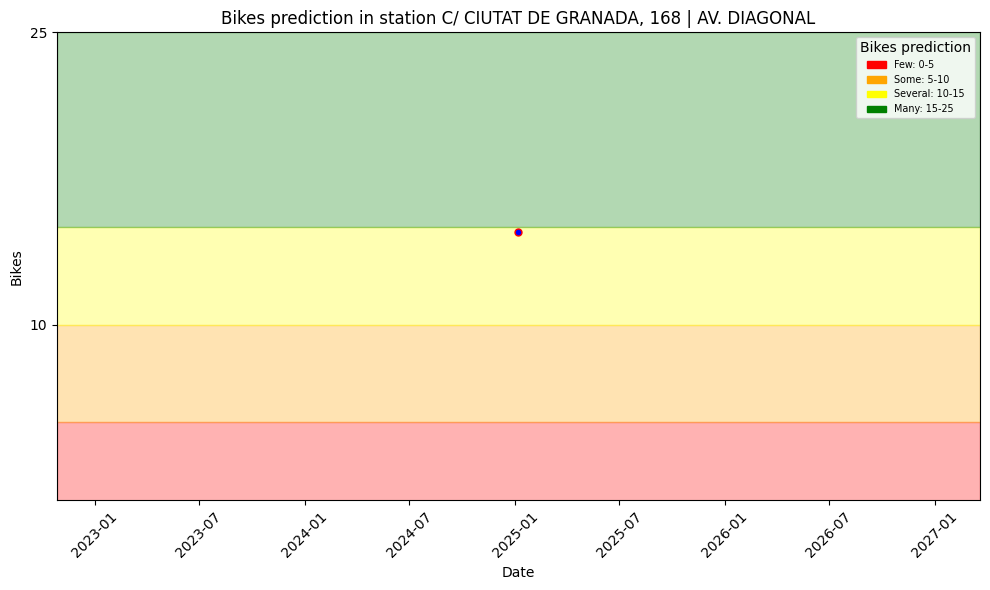

In [93]:
file_path = "../../docs/bikes/assets/img/bikes_prediction.png"
# rename predicted_num_bikes_available to num_bikes_available
plt = util.plot_bikes_prediction(batch_data, file_path) 
plt.show()

In [16]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='bikes_predictions',
    description='Bikes availability prediction monitoring',
    version=1,
    primary_key=['date'],
    event_time="date"
)

In [17]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1164440/fs/1155143/fg/1393682


Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: bikes_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1164440/jobs/named/bikes_predictions_1_offline_fg_materialization/executions
2025-01-07 10:39:49,478 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-07 10:39:52,638 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-07 10:41:47,474 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-07 10:41:47,630 INFO: Waiting for log aggregation to finish.
2025-01-07 10:42:06,154 INFO: Execution finished successfully.


(Job('bikes_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [51]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.read().sort_values(by='date', ascending=False).head(5)
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.71s) 


,date,precipitation,temperature,city,time,day,is_weekend,is_holiday,prev_num_bikes_available,predicted_num_bikes_available
0,2025-01-07 10:00:00+00:00,0.0,9.4,Barcelona,10,2025-01-07,False,False,16.0,15.512641


In [52]:
bikes_fg = fs.get_feature_group(
    name='bikes',
    version=1,
)
bikes_df = bikes_fg.read()
bikes_df = bikes_df.sort_values(by='date', ascending=False).head(5)
bikes_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


,day,time,num_bikes_available,date,is_weekend,is_holiday,prev_num_bikes_available
723,2025-01-07,8,16.000000,2025-01-07 08:00:00+00:00,False,False,11.000000
722,2025-01-04,11,11.000000,2025-01-04 11:00:00+00:00,True,False,19.250000
402,2024-10-31,23,19.250000,2024-10-31 23:00:00+00:00,False,False,18.166667
372,2024-10-31,22,18.166667,2024-10-31 22:00:00+00:00,False,False,15.833333
718,2024-10-31,21,15.833333,2024-10-31 21:00:00+00:00,False,False,18.583333


In [53]:
outcome_df = bikes_df[['date', 'num_bikes_available']]
preds_df =  monitoring_df[['date', 'predicted_num_bikes_available']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date", how="outer")
hindcast_df = hindcast_df.sort_values(by=['date'])
hindcast_df

,date,predicted_num_bikes_available,num_bikes_available
5,2024-10-31 21:00:00+00:00,NaN,15.833333
4,2024-10-31 22:00:00+00:00,NaN,18.166667
3,2024-10-31 23:00:00+00:00,NaN,19.250000
2,2025-01-04 11:00:00+00:00,NaN,11.000000
1,2025-01-07 08:00:00+00:00,NaN,16.000000
0,2025-01-07 10:00:00+00:00,15.512641,NaN


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

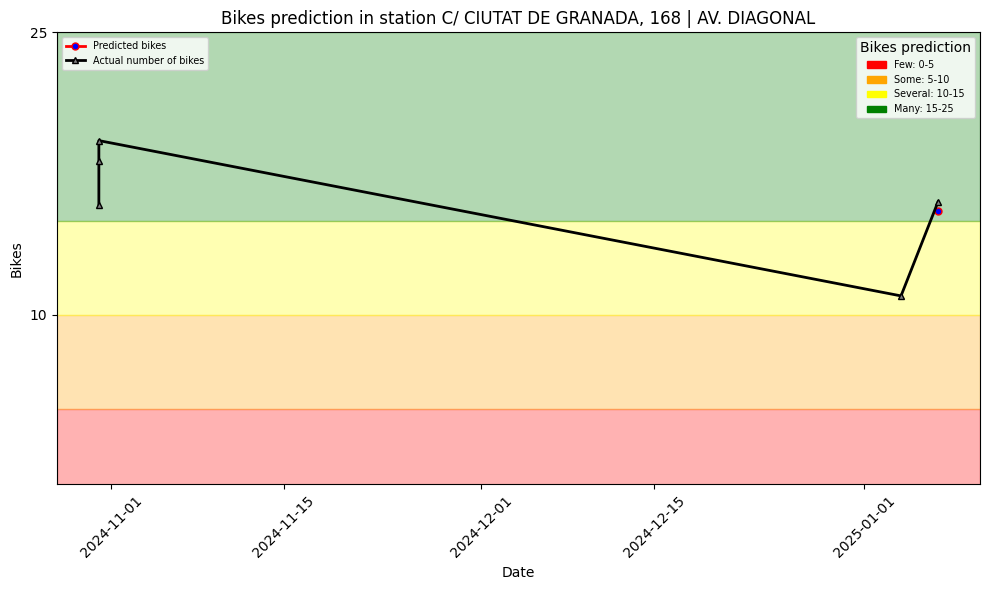

In [61]:
file_path = "../../docs/bikes/assets/img/bikes_hindcast.png"
plt = util.plot_bikes_prediction(hindcast_df, file_path, hindcast=True) 
plt.show()

---